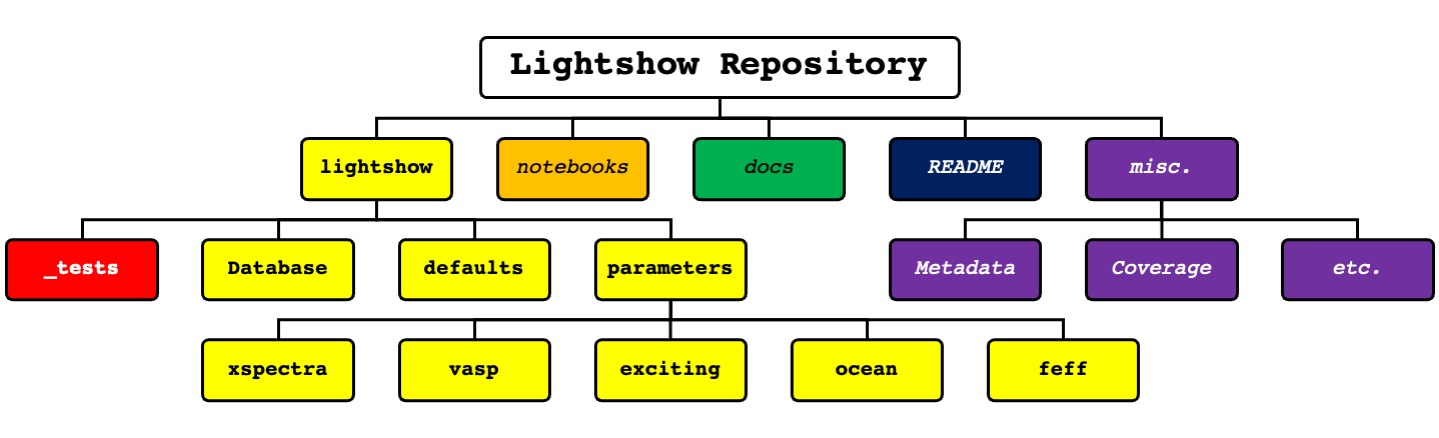

# Lightshow Basic Usage

The Lightshow software package is a one-stop-shop for writing computational spectroscopy input files. In this tutorial, we'll show you how to initialize a `Database` object from the Materials Project, and use that database to write input files for both the FEFF and VASP codes.

**Note:** Run this notebook from within `Lightshow/notebooks`, that way the paths all align.

In [ ]:
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

So the paths work:

In [ ]:
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent))

In [ ]:
from pprint import pprint

## Summary

Below, we showcase a workflow for performing a two-step process for constructing a structure-spectra (or more generally, structure-property) database for future use in e.g. data-driven analysis techniques, or simply for convenience.
1. Database construction: information is pulled from the Materials Project.
2. Input file writing: all input files for the desired calculations are saved systematically. This includes all desired metadata and the precise states of all of the input file writers.

**Note:** For convenience, set your Pymatgen API key in an environment variable called `PMG_API_KEY`. Alternatively, you can pass it directly when calling the `from_materials_project` classmethod below.

# Demo

The Lightshow API is designed with simplicity in mind. It contains two core objects: the `Database` and parameter files that inherit from `lightshow.parameters._base._BaseParameters`.

## The `Database` object

You can import the `Database` object via

```python
from lightshow import Database
```

It is a lightweight wrapper for two primary pieces of information. The structures

```python
db = Database(...)
db.structures
```

which is a dictionary of keys (which usually represent Materials Project IDs) and `pymatgen.core.structure.Structure` objects.

The second piece of information is the metadata:

```python
db.metadata
```

which generally is curated metadata from the Materials Project.

Let's import the `Database` object below and instantiate it from two Materials, `mp-390` and `mvc-11115`. In the cells below, the Pymatgen API key is read from an environment variable, but you can always pass it directly to any of the `Database` classmethods by using the `api_key` keyword argument.

In [ ]:
from lightshow import Database

In [ ]:
database = Database.from_materials_project(["mp-390", "mvc-11115"])

You can always access the structures, metadata and any errors that were logged during the retrieval of the data:

## The `Parameters` and workflow

Once the `Database` is created, you can write various input files for each type of spectroscopy code of interest. Currently available are:
* FEFF
* VASP
* XSpectra
* EXCITING
* OCEAN

though for this tutorial we'll focus on FEFF and VASP. The remaining workflow goes as such:
1. Instantiate a parameter object for each of the input files of interest
2. Pass those parameter objects to the `Database` `write` method

Let's import the parameters we need.

In [ ]:
from lightshow import FEFFParameters, VASPParameters, OCEANParameters, EXCITINGParameters, XSpectraParameters

Each parameter type takes different arguments. We also note that there are some defaults that you can make use of, and modify accordingly. For example, we'll use the `VASP_INCAR_DEFAULT_COREHOLE_POTENTIAL` default:

In [ ]:
from lightshow.defaults import VASP_INCAR_DEFAULT_COREHOLE_POTENTIAL

Next let's construct the FEFF inputs, which mimic Pymatgen's API, but allow for easier systematic input file generation, which we'll explain when we run the `write` method.

The `FEFFParameters` takes a few core arguments, including `cards` (which generally just mimic that of the FEFF input file itself), `edge` (for the type of edge you want, e.g. `"K"` or `"L3"`) and `radius`. The `radius` key is very important, as this determines the size of the cluster, with respect to the absorbing atom, that will be generated and saved.

In [ ]:
feff_params = FEFFParameters(
    cards={
        "S02": "0",
        "COREHOLE": "RPA",
        "CONTROL": "1 1 1 1 1 1",
        "XANES": "4 0.04 0.1",
        "SCF": "7.0 0 100 0.2 3",
        "FMS": "9.0 0",
        "EXCHANGE": "0 0.0 0.0 2",
        "RPATH": "-1"
    },
    edge="K",
    radius=10.0
)

Next, we'll do the same thing for VASP. This is a bit more complex, since VASP requires quite a few different types of input files. Check out the documentation to see exactly what each of these do. For now, we'll use many of the defaults.

In [ ]:
vasp_params_corehole = VASPParameters(
    incar=VASP_INCAR_DEFAULT_COREHOLE_POTENTIAL,
    potcar_directory=None,  # Read from the environment variable VASP_POTCAR_DIRECTORY
    force_spin_unpolarized=False
)

And now the same for OCEAN.

In [ ]:
ocean_params = OCEANParameters(
    edge="K"
)

EXCITING requires two types of input files. The `input.xml` and the species files. Please refer to the exciting documentation on what they do. The `input.xml` is created by Lightshow, for the species files you can tell Lightshow the path to. By default, Lightshow sets the calculation directory as species path. In this case, before running the calculations, you have to copy them to directories by hand.

The `EXCITINGParameters` take as the other ones the arguments `cards` (which generally mimics the EXCITING input itself; refer the EXCITING documentation for details) and `edge` (as for the other codes). Additionally, you can set the most important calculational parameters:
 - `kpoints` a method for defining the number of **k**-points in each lattice direction.
 - `nbands` a method for defining the number of unoccupied bands to be considered.

The most basic example for generating input files for `K` edge absorption calculations is given by:

In [ ]:
exciting_params = EXCITINGParameters(
    edge="K"
)

XSpectra calculates the XANES spectra in two steps: an scf calculation and a spectra calcualtion. The `es.in` is the input file of the prerequisite scf calculation, which is based on Quantum Espresso. The `xanes.in` is the input file for the spectra calcualtions. Three folders named as `dipole{1..}` will be generated by Lightshow, corresponding the three polar directions. The `gs.in` used for the ground state calculation will also be generated.

XSpectra requires core-hole pseudo potential for the absorbing atom in `es.in`. Lightshow does not provide any core-hole pseudo potential along with its release. Users need to generate corresponding the core-hole pseudo potential by themselves. Users also need to take care of the pseudo potentials for the elements other than the absorber. In the input files like `es.in` and `gs.in`, a placeholder for pseduo potential of each element is used, for example, Ti.upf.

If the users have a pseudo potential database they want to link, such as [SSSP database](https://www.materialscloud.org/discover/sssp/table/precision), they can point to the directory for the database 
 using `psp_directory` parameter. Besides, they will also need to create a cutoff table containing some basic information about the database and provide the name of the cutoff table to `psp_cutoff_table`. An example of the cutoff table looks like:
```
        cutoff_table = {
                'Ag': {'filename': 'Ag.upf',
                'cutoff_wfc': 50.0,
                'cutoff_rho': 200.0},
        }
```
where the keys are element names, and inside it are the filename, cutoff_wfc, and cutoff_rho. By setting the `psp_directory` and corresponding `psp_cutoff_table`, Lightshow will copy the pseudo potential files to the working directory and take care of the pseudo potential filename and corresponding energy cutoffs in the input files. 

The `XSpectraParameters` takes the argumentes `card` and `edge`. In the `card`, `QE` key governs the basic parameter for Quantum Espresso calculation; `XS` determines the XANES calcualtion. But for now, we will mainly focus on the defalts settings. 

In [ ]:
xspectra_params = XSpectraParameters(
    edge="K"
)

## Write

Once the parameter files are created, we can call the `write` method. This does a few things, and reading the documentation for `write` is advised. However, for starters, note that there are a few key parameters that should be set in general.
* `root`: the root directory for saving the files. Everything gets saved here.
* `absorbing_atom`: when doing any spectroscopy calculation, the `absorbing_atom` must be specified. The exception to this is for "global" calculations, such as a pure SCF VASP calculation, where `absorbing_atom=None` is permitted.
* `options`: this is a list of the parameter files you've defined above. This tells `write` which types of spectroscopy input files to create.
* There are also various "global" property cutoffs the user can specify, such as `max_primitive_total_atoms`, which should be self-explanatory. For now though, leaving them as the default causes them to behave sensibly.

In [ ]:
database.write("test", options=[feff_params, vasp_params_corehole, ocean_params, exciting_params, xspectra_params], absorbing_atoms=["Ti", "O"])

# MSONable

Every object of importance in `Lightshow` can be serialized as a Python dictionary. This allows users to save any object they want and reload it from disk in a readable way, significantly extending the transparency of the core objects. For example:

In [ ]:
pprint(database.as_dict())
pprint(feff_params.as_dict())
pprint(vasp_params_corehole.as_dict())
pprint(ocean_params.as_dict())

The code makes use of this ability during the use of `write`, where an object `writer_metadata.json` is always saved, which details every aspect of the input files. 